####Projeto de Classificação de Textos com Modelos de Machine Learning

Este projeto utiliza três modelos de **Machine Learning** - `Naive Bayes`, `Regressão Logística` e `Random Forest` - para realizar a classificação de textos em um conjunto de dados de **tweets**. O objetivo é comparar a capacidade desses modelos em identificar padrões nos textos e fornecer previsões precisas de classificação sentimentos em positivo ou negativo.



In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier


In [7]:
# Carregar o dataset com encoding latin-1 e especificando nomes das colunas
data = pd.read_csv(
    '/content/training.1600000.processed.noemoticon.csv',
    encoding='latin-1',
    header=None,  # indica que o arquivo não tem cabeçalho
    names=["target", "ids", "date", "flag", "user", "text"]
)
data = data.sample(100000, random_state=42)  # Reduzindo para 100.000 amostras
# Visualizar as primeiras linhas
print(data.head())

        target         ids                          date      flag  \
541200       0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
750          0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
766711       0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
285055       0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
705995       0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

                   user                                               text  
541200  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!   
750         sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...  
766711       sammydearr  @TiannaChaos i know  just family drama. its la...  
285055      Lamb_Leanne  School email won't open  and I have geography ...  
705995      yogicerdito                             upper airways problem   


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 541200 to 429504
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  100000 non-null  int64 
 1   ids     100000 non-null  int64 
 2   date    100000 non-null  object
 3   flag    100000 non-null  object
 4   user    100000 non-null  object
 5   text    100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [25]:
# Distribuição absoluta
classe_absoluta = data['target'].value_counts()
print("Distribuição absoluta entre as classes:\n", classe_absoluta)

# Distribuição percentual
classe_percentual = data['target'].value_counts(normalize=True) * 100
print("\nDistribuição percentual entre as classes:\n", classe_percentual)

Distribuição absoluta entre as classes:
 target
4    50057
0    49943
Name: count, dtype: int64

Distribuição percentual entre as classes:
 target
4    50.057
0    49.943
Name: proportion, dtype: float64


O trecho de código abaixo realiza o pré-processamento de textos utilizando diferentes técnicas de processamento de linguagem natural (NLP) com a ajuda das bibliotecas spaCy e NLTK. Inicialmente, o modelo en_core_web_sm da biblioteca spaCy é carregado, e algumas ferramentas do NLTK, como stopwords, tokenização e lematizador (WordNetLemmatizer), são baixadas e preparadas. As stopwords em inglês são armazenadas para serem utilizadas no pré-processamento dos textos.

Três funções diferentes são definidas para limpar os textos:

clean_text_basic faz uma limpeza básica dos textos, removendo URLs, menções e caracteres especiais, convertendo o texto para minúsculas.
preprocess_texts_spacy utiliza a biblioteca spaCy para processar os textos em paralelo, aplicando lematização e removendo stopwords e pontuações, tornando o texto mais uniforme para ser analisado.
clean_text_nltk utiliza a biblioteca NLTK para fazer o pré-processamento, que inclui a remoção de URLs, menções e caracteres especiais, além da tokenização e lematização com a remoção de stopwords.
Finalmente, o código aplica cada uma dessas funções ao dataset data, criando três novas colunas (text_basic, text_spacy e text_nltk) que contêm versões dos textos pré-processados de maneiras diferentes, proporcionando abordagens distintas para se preparar o texto para análises e modelos de aprendizado de máquina. Isso permite comparar o impacto de cada técnica de pré-processamento no desempenho dos modelos subsequentes.

In [9]:
nlp = spacy.load("en_core_web_sm")

# Inicializar NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# Função de pré-processamento básica
def clean_text_basic(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text.lower()

# Função de pré-processamento com spaCy utilizando paralelização
def preprocess_texts_spacy(texts):
    docs = list(nlp.pipe(texts, batch_size=50, n_process=-1))  # Utilizando paralelização para melhorar o desempenho
    processed_texts = [" ".join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]) for doc in docs]
    return processed_texts

# Função de pré-processamento com NLTK
def clean_text_nltk(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Criar novas colunas com diferentes versões de texto limpo a partir do dataset carregado
data['text_basic'] = data['text'].apply(clean_text_basic)
data['text_spacy'] = preprocess_texts_spacy(data['text'].values)
data['text_nltk'] = data['text'].apply(clean_text_nltk)



/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


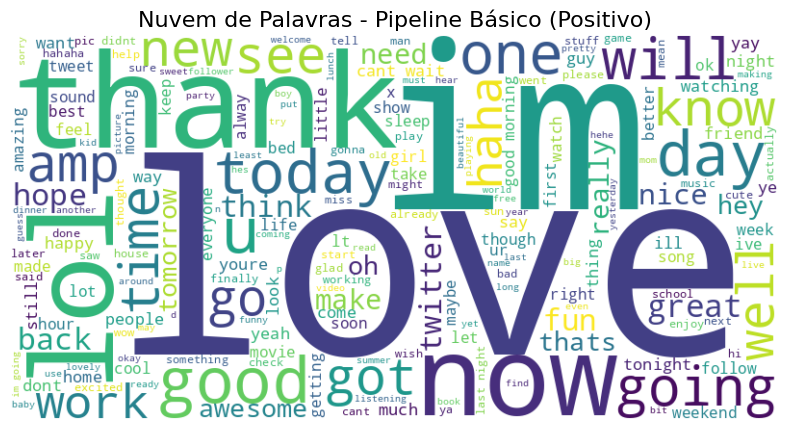

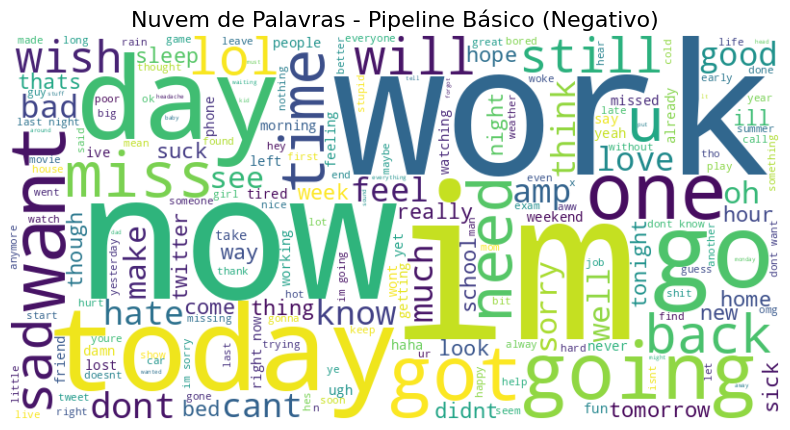

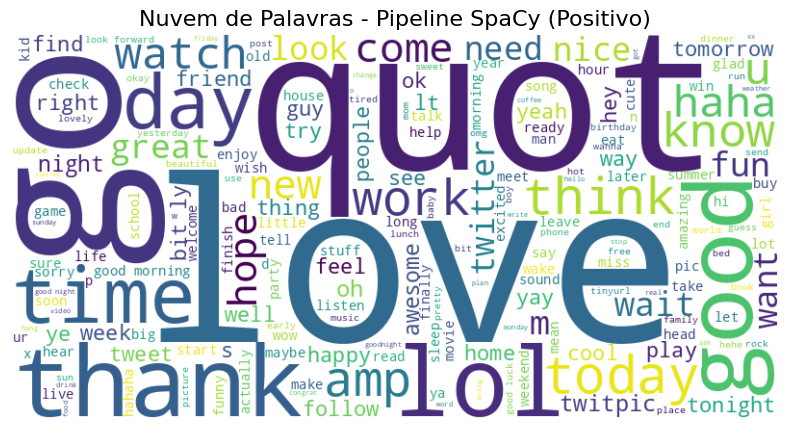

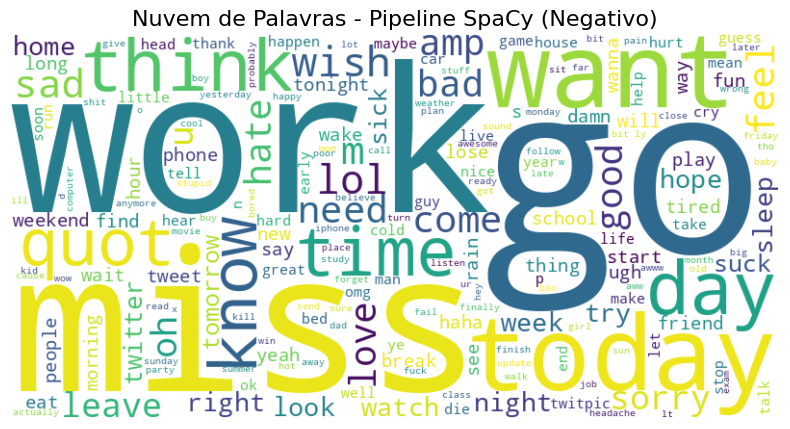

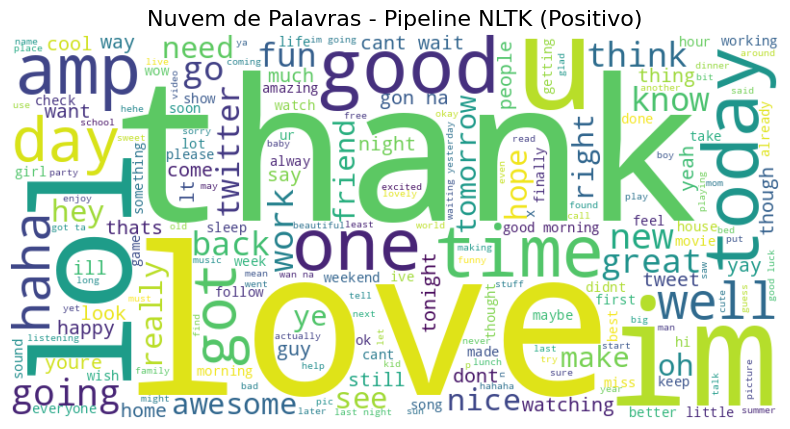

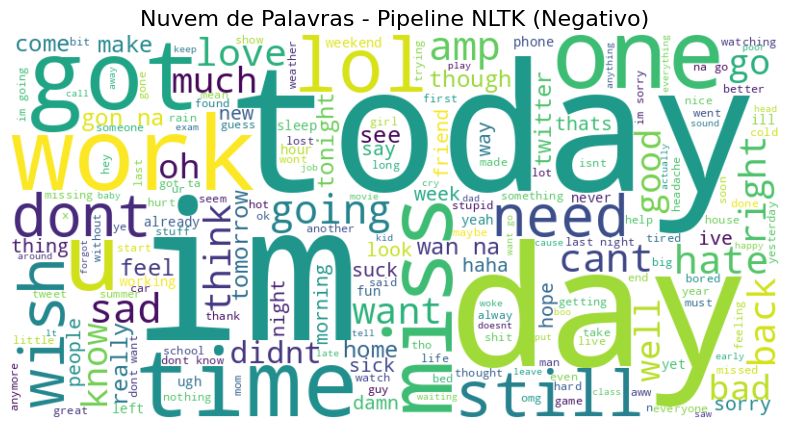

In [10]:
# Separar mensagens positivas e negativas para cada técnica de NLP
positive_text_basic = ' '.join(data[data['target'] == 4]['text_basic'])
negative_text_basic = ' '.join(data[data['target'] == 0]['text_basic'])

positive_text_spacy = ' '.join(data[data['target'] == 4]['text_spacy'])
negative_text_spacy = ' '.join(data[data['target'] == 0]['text_spacy'])

positive_text_nltk = ' '.join(data[data['target'] == 4]['text_nltk'])
negative_text_nltk = ' '.join(data[data['target'] == 0]['text_nltk'])

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Nuvens de palavras para o pipeline básico
plot_wordcloud(positive_text_basic, "Nuvem de Palavras - Pipeline Básico (Positivo)")
plot_wordcloud(negative_text_basic, "Nuvem de Palavras - Pipeline Básico (Negativo)")

# Nuvens de palavras para o pipeline spaCy
plot_wordcloud(positive_text_spacy, "Nuvem de Palavras - Pipeline SpaCy (Positivo)")
plot_wordcloud(negative_text_spacy, "Nuvem de Palavras - Pipeline SpaCy (Negativo)")

# Nuvens de palavras para o pipeline NLTK
plot_wordcloud(positive_text_nltk, "Nuvem de Palavras - Pipeline NLTK (Positivo)")
plot_wordcloud(negative_text_nltk, "Nuvem de Palavras - Pipeline NLTK (Negativo)")

Abaixo é feita a definição e avaliação de três modelos de classificação de texto, utilizando diferentes pipelines de pré-processamento. Primeiro, são definidos três modelos de Machine Learning — Naive Bayes, Logistic Regression e Random Forest. Esses modelos são então usados para classificar o texto dos tweets em sentimentos positivos ou negativos.

A função train_and_evaluate(text_column) recebe o nome de uma coluna do dataset que contém os textos pré-processados. Essa função realiza o pré-processamento adicional necessário para preparar os textos para os modelos, utilizando o método TF-IDF para vetorização, que converte os textos em vetores numéricos que podem ser usados como entrada nos modelos de aprendizado.

O dataset vetorizado é então dividido em conjuntos de treinamento e teste usando train_test_split, com 80% dos dados sendo usados para treinar os modelos e 20% para avaliá-los. O código imprime o tamanho de cada conjunto para facilitar o acompanhamento.

Para cada modelo no dicionário models, a função treina o modelo (fit()) nos dados de treinamento e, em seguida, usa o conjunto de teste para prever as classes dos exemplos (predict()). O desempenho de cada modelo é avaliado por meio do relatório de classificação (classification_report), que fornece métricas como precisão, revocação e F1-score para cada classe. Esses relatórios são armazenados no dicionário results e impressos para cada modelo.

Por fim, a função train_and_evaluate() é chamada para cada um dos pipelines de pré-processamento (text_basic, text_spacy, text_nltk), permitindo que o desempenho dos modelos seja avaliado com diferentes formas de pré-processamento de texto. Isso ajuda a identificar qual técnica de pré-processamento e qual modelo de classificação funciona melhor para o problema de classificação de sentimentos dos tweets.

In [24]:
# Definir os modelos
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier()
}

# Função para treinar e avaliar cada pipeline
def train_and_evaluate(text_column):
    # Vetorização usando TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(data[text_column])
    y = data['target']

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Exibir tamanho dos conjuntos
    print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
    print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")

    # Resultados
    results = {}
    for model_name, model in models.items():
        print(f"\nTreinando e avaliando o modelo: {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred)
        results[model_name] = report
        print(report)


    return results

# Avaliar para cada pipeline de NLP
results_basic = train_and_evaluate('text_basic')
results_spacy = train_and_evaluate('text_spacy')
results_nltk = train_and_evaluate('text_nltk')

Tamanho do conjunto de treino: 80000
Tamanho do conjunto de teste: 20000

Treinando e avaliando o modelo: Naive Bayes
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      9995
           4       0.76      0.75      0.76     10005

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000


Treinando e avaliando o modelo: Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      9995
           4       0.77      0.79      0.78     10005

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000


Treinando e avaliando o modelo: Random Forest
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      9995
           4       